In [ ]:
!pip install transformers datasets accelerate sklearn
!pip install torch --upgrade

  Using cached datasets-3.5.0-py3-none-any.whl.metadata (19 kB)
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import torch
print("GPU available:", torch.cuda.is_available())

from transformers import pipeline
pipe = pipeline("text-classification", device=0)

GPU available: True


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install datasets

  Using cached datasets-3.5.0-py3-none-any.whl.metadata (19 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.


In [ ]:
import re
import string

import numpy as np
import pandas as pd
import tensorflow as tf
from datasets import Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, f1_score, ConfusionMatrixDisplay

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer, EarlyStoppingCallback
from accelerate import Accelerator

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def load_dataset(file_path):
    """
    Loads the dataset
    Returns:
    - pd.DataFrame: Dataset in DataFrame format.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Exiting program.")
        sys.exit(1)

def clean_text(text):
    """Pre-process text and generate tokens
    Args:
        text: Text to tokenize.
    Returns:
        Tokenized text.
    """
    text = str(text).lower()

    text = re.sub(r"@\w+", "", text)  # Remove mentions (@user)
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text

def data_transformation(file_path):
    """
    Loads and preprocesses text datasets and apply tokenization.
    This function performs the following steps:
    1. Loads the dataset.
    2. Cleans the text data (tokenization, stopword removal).
    3. Creates a new column for tokenized words and a string version of tokens.
    Returns:
    The processed dataset.
    """
    # Loads datasets
    tweets_df = load_dataset(filepath)

    # Fill NaN values with empty strings
    tweets_df["text"] = tweets_df["text"].fillna("")
    tweets_df["cleaned_text"] = tweets_df['text'].map(lambda x: clean_text(x))

    # Encoding Category Columns for future use
    label_encoder = LabelEncoder()
    tweets_df["sentiment_encoded"] = label_encoder.fit_transform(tweets_df["airline_sentiment"])

    return tweets_df

def split_dataset(df, stratify,  test_size=0.2, val_size=0.1, ):
    """
    Splits dataset into train, validation, and test sets
    Args:
        df: Input DataFrame
        stratify: y, keeps class distribution balanced
        test_size: Proportion for test set (default 0.2)
        val_size: Proportion of training set to use for validation (default 0.1)
    Returns:
        train_df, val_df, test_df: Properly split datasets
    """
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42, stratify=df[stratify])
    train_df, val_df = train_test_split(train_df, test_size=val_size/(1-test_size), random_state=42, stratify=train_df[stratify])
    return train_df, test_df, val_df

In [ ]:
filepath = '/content/drive/MyDrive/AI_Factory/Tweets.csv'
tweets_df = data_transformation(filepath)

In [ ]:
cleaned_df = tweets_df[['cleaned_text','sentiment_encoded']]
print(type(cleaned_df))
print(cleaned_df)

<class 'pandas.core.frame.DataFrame'>
                                            cleaned_text  sentiment_encoded
0                                              what said                  1
1      plus youve added commercials to the experience...                  2
2      i didnt today must mean i need to take another...                  1
3      its really aggressive to blast obnoxious enter...                  0
4                and its a really big bad thing about it                  0
...                                                  ...                ...
14635  thank you we got on a different flight to chicago                  2
14636  leaving over 20 minutes late flight no warning...                  0
14637     please bring american airlines to blackberry10                  1
14638  you have my money you change my flight and don...                  0
14639  we have 8 ppl so we need 2 know how many seats...                  1

[14640 rows x 2 columns]


In [ ]:
train_df, test_df, val_df = split_dataset(df = cleaned_df, stratify = 'sentiment_encoded')

In [ ]:
def tokenization(df, text_col, label_col=None):
    # Load Tokenizer
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    # Convert DataFrame to Hugging Face Dataset
    dataset = Dataset.from_pandas(df)

    # Tokenization function
    def tokenize_data(examples):
        # Tokenize the text column
        tokenized = tokenizer(
            examples[text_col],
            truncation=True,
            padding='max_length',
            max_length=128
        )

        # Add labels if a label column is provided
        if label_col and label_col in examples:
            tokenized['labels'] = examples[label_col]
        return tokenized

    # Apply tokenization
    tokenized_dataset = dataset.map(tokenize_data, batched=True, remove_columns=[text_col, label_col])

    return tokenized_dataset

In [ ]:
tokenized_train = tokenization(train_df, text_col='cleaned_text', label_col='sentiment_encoded')
tokenized_test = tokenization(test_df, text_col='cleaned_text', label_col='sentiment_encoded')
tokenized_val = tokenization(val_df, text_col='cleaned_text', label_col='sentiment_encoded')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/2928 [00:00<?, ? examples/s]

Map:   0%|          | 0/1464 [00:00<?, ? examples/s]

In [ ]:
tokenized_train

Dataset({
    features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 10248
})

In [ ]:
from collections import Counter
print("Train:", Counter(tokenized_train["labels"]))
print("Val:", Counter(tokenized_val["labels"]))

Train: Counter({0: 6425, 1: 2169, 2: 1654})
Val: Counter({0: 918, 1: 310, 2: 236})


In [ ]:
from torch.optim import AdamW
from transformers import AutoConfig, DataCollatorWithPadding
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch.nn import CrossEntropyLoss

config = AutoConfig.from_pretrained("distilbert-base-uncased", num_labels=3, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.1)

# Load pretrained DistilBERT
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config).to("cuda")

# Define training arguments
training_args = TrainingArguments(
    report_to="none",
    output_dir = '/content/drive/MyDrive/AI_Factory/results',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 1e-5,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    fp16=True,
    num_train_epochs = 3,
    weight_decay = 0.01, # Weight decay to prevent overfitting
    logging_dir = '/content/drive/MyDrive/AI_Factory/logs',
    logging_steps = 50,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss"
)

# Define function to compute evaluation metrics during training and evaluation
def compute_metrics(pred):
    """
    Compute accuracy, precision, recall, and F1 score based on model predictions.
    Args:
        pred: The predictions from the model containing labels and predictions.
    Returns:
        dict: A dictionary containing 'accuracy', 'precision', 'recall', and 'f1' scores.
    """
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    metrics = {
        'accuracy': accuracy_score(labels, preds),
        'macro_f1': f1_score(labels, preds, average='macro'),
        'weighted_f1': f1_score(labels, preds, average='weighted')
    }
    # Add per-class scores
    for i, class_name in enumerate(['negative', 'neutral', 'positive']):
        metrics[f'f1_{class_name}'] = f1_score(labels, preds, labels=[i], average='micro')
    return metrics

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Set up early stopping callback if no improvement after 1 epochs
early_stopping = EarlyStoppingCallback(early_stopping_patience=1)

optimizer = AdamW(model.parameters(), lr=1e-5)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(tokenized_train["labels"]),
    y=tokenized_train["labels"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda")

# Define weighted loss function
loss_fn = CrossEntropyLoss(weight=class_weights)

# Modify Trainer to use custom loss function
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Prepare data collator for padding sequences
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize Trainer for fine-tuning the model
trainer = CustomTrainer(
    optimizers=(optimizer, None),
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
)

train_result = trainer.train()

trainer.save_model("/content/drive/MyDrive/AI_Factory/sentiment_model")
tokenizer.save_pretrained("/content/drive/MyDrive/AI_Factory/sentiment_model")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-28-2c26e8507d93>:84: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1,F1 Negative,F1 Neutral,F1 Positive
1,0.582500,0.623721,0.827186,0.768976,0.824718,0.898876,0.674576,0.733475
2,0.543500,0.619336,0.828552,0.776403,0.829291,0.900219,0.681600,0.747390
3,0.338100,0.713464,0.829235,0.777426,0.830764,0.901766,0.686709,0.743802


('/content/drive/MyDrive/AI_Factory/sentiment_model/tokenizer_config.json',
 '/content/drive/MyDrive/AI_Factory/sentiment_model/special_tokens_map.json',
 '/content/drive/MyDrive/AI_Factory/sentiment_model/vocab.txt',
 '/content/drive/MyDrive/AI_Factory/sentiment_model/added_tokens.json',
 '/content/drive/MyDrive/AI_Factory/sentiment_model/tokenizer.json')

In [ ]:
def plot_loss_curves():
    """
    Plot the training and validation loss curves.
    """
    history = trainer.state.log_history

    train_loss = []
    val_loss = []
    val_epochs = []

    for i, log in enumerate(history):
        if "loss" in log:
            train_loss.append(log["loss"])
        if "eval_loss" in log:
            val_loss.append(log["eval_loss"])
            val_epochs.append(len(train_loss))  # Capture epoch index for validation loss

    print("Training Loss:", train_loss)
    print("Validation Loss:", val_loss)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_loss) + 1), train_loss, 'b-', label="Training Loss")
    plt.plot(val_epochs, val_loss, 'r-', marker='o', label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

Training Loss: [1.0859, 0.962, 0.8389, 0.7693, 0.6828, 0.6627, 0.611, 0.5754, 0.6288, 0.5676, 0.6288, 0.6245, 0.5633, 0.6213, 0.5311, 0.4911, 0.6326, 0.6226, 0.5502, 0.5729, 0.6187, 0.6241, 0.5491, 0.5416, 0.5825, 0.4726, 0.4125, 0.3556, 0.3972, 0.5576, 0.4146, 0.4845, 0.4968, 0.3955, 0.5427, 0.4298, 0.4307, 0.5114, 0.457, 0.4174, 0.4747, 0.516, 0.5188, 0.4625, 0.4617, 0.4481, 0.406, 0.4697, 0.3745, 0.48, 0.5435, 0.3609, 0.3409, 0.3126, 0.3641, 0.3327, 0.3043, 0.4968, 0.3882, 0.3851, 0.3777, 0.4383, 0.3513, 0.3763, 0.281, 0.3706, 0.3826, 0.3796, 0.3931, 0.4246, 0.3533, 0.4417, 0.4, 0.4645, 0.4451, 0.3381]
Validation Loss: [0.6237211227416992, 0.6193360090255737, 0.7134636044502258]


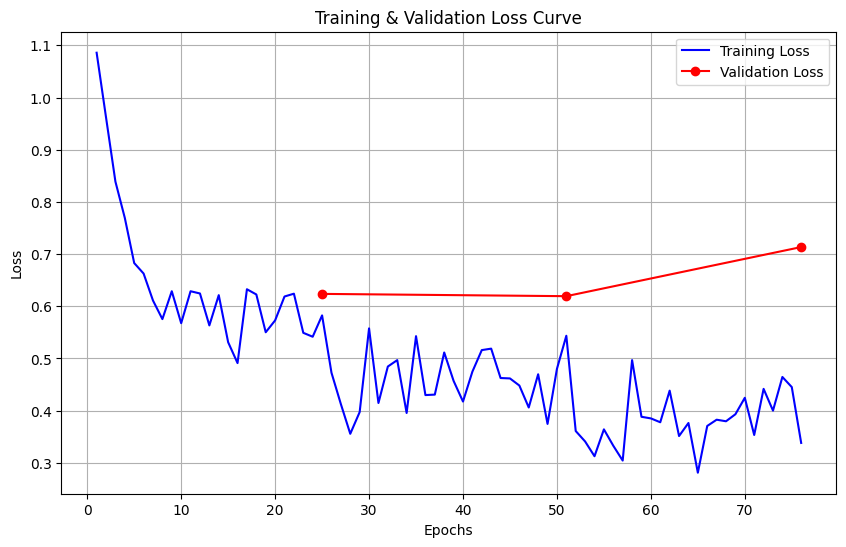

Test Results: {'eval_loss': 0.6064726710319519, 'eval_accuracy': 0.828551912568306, 'eval_macro_f1': 0.7824256116731837, 'eval_weighted_f1': 0.8298672626672519, 'eval_f1_negative': 0.8948816730875069, 'eval_f1_neutral': 0.6854460093896714, 'eval_f1_positive': 0.7669491525423728, 'eval_runtime': 5.7499, 'eval_samples_per_second': 509.226, 'eval_steps_per_second': 63.653, 'epoch': 3.0}


In [ ]:
# Plot the training loss curve
plot_loss_curves()

# Evaluate the model on the test set
test_results = trainer.evaluate(tokenized_test)
print(f"Test Results: {test_results}")

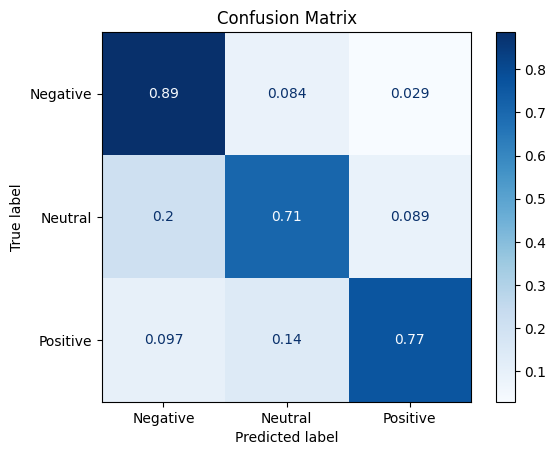

In [ ]:
# Predict the labels for the test set
preds = trainer.predict(tokenized_test)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

def plot_confusion_matrix(y_true, y_pred):
    """
    Plot and display the confusion matrix to evaluate model performance.
    """
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(y_true, y_pred)

In this project i fine-tuned the RoBERTa and DistilBERT models for sentiment
classification. Ultimately, i chose DistilBERT because is lighter and delivered better results. During the training i modified hidden_dropout_prob=0.3 and attention_probs_dropout_prob=0.1 to prevent overfitting. I used AdamW optimizer with weight decay to regularize the model and set early stopping to 1 epoch.  Model performance was evaluated after each epoch. I used compute_class_weight method to handle class imbalance because negative samples dominated and I implemented a custom loss function (loss_fn) to ensure that the model does not get biased toward more frequent sentiment classes. I observed that after the 3rd epoch, the model led to overfitting, so i limited training to 3 epochs. The best accuracy achieved by the model was 0.82. Overall, confunsion matrix suggests that the model struggled to distingush neutral from negative as well as a significant percentage of positive comments were misclassified. Loss curves plot shows that training loss(blue) steadily decreases, indicating that model is learning, but validation loss(red) increases, showing overfitting. A more balanced training data and probably additional data preprocessing might had lead to better results.